# Домашнее задание 3. Детекция объектов

Сыграем в квиддич? Или лучше в карты?

В этом дз вам предстоит написать практически с нуля архитектуру для детекции, а также воспользоваться готовым решением. На выбор даётся два датасета, отличаются они только картинками. Форматы, баллы - все одинаково.

Первый вариант это датасет по кадрам игры в квиддич из Гарри Поттера. Если вы забыли правила, то нажмите [сюда](https://harrypotter.fandom.com/ru/wiki/%D0%9A%D0%B2%D0%B8%D0%B4%D0%B4%D0%B8%D1%87). Вы научитесь искать и выделять на фотографиях бладжеры, квоффл и снитч.

Второй вариант это датасет с игральными картами. Если вы забыли что такое карты, то нажмите [сюда](https://ru.wikipedia.org/wiki/%D0%98%D0%B3%D1%80%D0%B0%D0%BB%D1%8C%D0%BD%D1%8B%D0%B5_%D0%BA%D0%B0%D1%80%D1%82%D1%8B). Вы научитесь искать и выделять на фотографиях несколько типов карт.

Оба варианта содержат около 300 картинок, данные хранятся в xml в формате PascalVOC. Есть малые отличия, но ничего страшного.


Если с самописным детектором совсем не получается, то можно после создания датасетов перейти к концу, где обучается готовый, с ним будет проще :)

# Notes

Дз проверялось на работоспособность в colab. Не гарантируется, что будет работать на чем-то другом, и точно не будет работать из коробки на Windows.

По вопросам формулировок (не ошибок торча!), в случае отсутствия ответа в общем чате (поиск по чату позволяет проверить), можно написать в него с тегом @markblumenau.

## Данные

Скачайте один из датасетов на свой вкус и начните работу с ним.
Разметка находится в xmls папке, картинки в images.

In [ ]:
# Harry Potter -- uncomment
!wget https://github.com/markblumenau/hw3_iad_dl/raw/main/harry/data.zip

# Cards -- uncomment
#!wget https://github.com/markblumenau/hw3_iad_dl/raw/main/cards/data.zip



!unzip -q data.zip

--2023-12-17 09:02:44--  https://github.com/markblumenau/hw3_iad_dl/raw/main/harry/data.zip
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/markblumenau/hw3_iad_dl/main/harry/data.zip [following]
--2023-12-17 09:02:45--  https://raw.githubusercontent.com/markblumenau/hw3_iad_dl/main/harry/data.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17592727 (17M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]  16.78M  --.-KB/s    in 0.09s   

2023-12-17 09:02:45 (185 MB/s) - ‘data.zip’ saved [17592727/17592727]


# Задача 1. 0.5 балла.

Ниже написан код для стандартного Dataset из библиотеки pytorch. Dataset требует реализации `__getitem__` и `__len__` методов. Далее эти методы будут использованы для формирования батчей для обучения. Поскольку читать придется из xml файлов, нужно перед этим дописать функцию get_xml_data, чтобы по названию картинки подтягивать аннотации.

In [1]:
import torch
from xml.etree import ElementTree as ET
from typing import List, Dict, Tuple, Any
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from pathlib import Path
import glob
import numpy as np
from PIL import Image
import torchvision
from tqdm.notebook import tqdm
from torch import nn
import shutil
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import json
import os
import matplotlib.pyplot as plt
from torch import Tensor
import cv2
from matplotlib import patches
from torchvision.models import resnet50

In [2]:
def get_xml_data(image_name: str,
                 root: str,
                 class_dict: Dict[str, int],
                 xml_prefix: str = "/xmls/") -> List[List[int]]:
    """
    Получение данных из XML-файла для изображения.

    :param image_name: Путь к изображению (название файла).
    :param root: Корневая директория, в которой находятся XML-файлы.
    :param class_dict: Словарь, сопоставляющий имена классов их идентификаторам.
    :param xml_prefix: Префикс пути к XML-файлам (по умолчанию "/xmls/").
    :return: Список ограничивающих рамок (bbox) и соответствующих им классов.
    """
    # Получение имени файла из полного пути, например, "ZZZ/YYY/XXXXXX.jpg" -> "XXXXXX"
    filename = image_name.split("/")[-1].split(".")[0]
    # Чтение XML-файла
    tree = ET.parse(str(root) + xml_prefix + filename + ".xml")
    treeroot = tree.getroot()
    # Итерация по ограничивающим рамкам (bbox)
    bboxes: List[List[int]] = []
    for member in treeroot.findall("object"):
        # Извлечение координат xmin, ymin, xmax, ymax и соответствующего класса из XML
        xmin = int(member.find("bndbox").find("xmin").text)
        ymin = int(member.find("bndbox").find("ymin").text)
        xmax = int(member.find("bndbox").find("xmax").text)
        ymax = int(member.find("bndbox").find("ymax").text)
        class_name = member.find("name").text
        class_id = class_dict[class_name]

        # Сбор информации о bbox и классе в список и добавление его в список bbox'ов
        res = [xmin, ymin, xmax, ymax, class_id]
        bboxes.append(res)

    return bboxes

In [3]:
class PascalDataset(Dataset):
    def __init__(self, *, transform, root="dataset", train=True, seed=42):
        """
        Конструктор класса PascalDataset.

        :param transform: Преобразование для изображений и bounding boxes.
        :param root: Корневая директория датасета.
        :param train: Флаг, указывающий, используется ли датасет для обучения (True) или тестирования (False).
        :param seed: Значение для инициализации генератора случайных чисел.
        """
        self.root = Path(root)
        self.transform = transform

        assert self.root.is_dir(), f"No data at `{root}`"

        self.filenames = np.array(glob.glob(str(self.root / "images") + "/*"))
        with open(str(self.root / "class_dict"), "r") as f:
            self.class_dict = eval(f.readline())

        self.class_dict_inv = {v: k for k, v in self.class_dict.items()}

        np.random.seed(seed)
        permutation = np.random.permutation(len(self.filenames))

        # Train/test split
        if train:
            self.filenames = self.filenames[
                permutation[: int(len(self.filenames) * 0.9)]
            ].tolist()
        else:
            self.filenames = self.filenames[
                permutation[int(len(self.filenames) * 0.9) :]
            ].tolist()

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, List[List[int]]]:
        """
        Получение элемента датасета по индексу.

        :param idx: Индекс элемента.
        :return: Кортеж, содержащий тензор изображения и список ограничивающих рамок (bbox) с классами.
        """
        fname = self.filenames[idx]
        image = np.array(Image.open(fname).convert("RGB"))
        bboxes = get_xml_data(fname, self.root, self.class_dict)

        # Применяем трансформации, если они предоставлены
        if self.transform:
            transformed = self.transform(image=image, bboxes=bboxes)
            image = transformed['image']
            bboxes = transformed['bboxes']

        return torch.from_numpy(image.transpose(2, 0, 1)), bboxes

    def __get_raw_item__(self, idx: int) -> Tuple[str, List[List[int]]]:
        """
        Получение необработанного элемента датасета по индексу.

        :param idx: Индекс элемента.
        :return: Кортеж, содержащий имя файла и список ограничивающих рамок (bbox) с классами.
        """
        fname = self.filenames[idx]
        return fname, get_xml_data(fname, self.root, self.class_dict)

    def __len__(self) -> int:
        """
        Получение длины датасета.

        :return: Количество элементов в датасете.
        """
        return len(self.filenames)

Ниже определяем стандартные нормализации и приведение размера к 512x512.


In [4]:
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

train_transform = A.Compose(
    [
        A.Resize(512, 512),
        A.augmentations.transforms.Normalize(mean=mean, std=std),
        ToTensorV2(),
    ],
    bbox_params=dict(format="pascal_voc", min_visibility=0.3),
)

test_transform = A.Compose(
    [
        A.Resize(512, 512),
        A.augmentations.transforms.Normalize(mean=mean, std=std),
        ToTensorV2(),
    ],
    bbox_params=dict(format="pascal_voc", min_visibility=0.5),
)

In [5]:
train_ds = PascalDataset(root="./data/", transform=train_transform, train=True)
test_ds = PascalDataset(root="./data/", transform=test_transform, train=False)

# Задача 2. 1 балл.

Теперь, когда мы загрузили данные, хорошо бы посмотреть на них, прежде чем обучать какие-либо модели. Напишите функцию `visualize`, которая принимает списки изображений и прямоугольников в качестве входных данных и рисует эти прямоугольники на изображениях.


Полезные функции:
* [plt.subplots](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplots.html) -- легко создавать несколько изображений в одной pyplot figure
* [ax.imshow](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.imshow.html) -- отображение графиков (не забудьте откатить нормализацию)
* [ax.text](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.text.html), [patches.Rectangle](https://matplotlib.org/stable/api/_as_gen/matplotlib.patches.Rectangle.html) -- для рисования прямоугольников и текста с аннотацией

In [6]:
def visualize(images, bboxes):
    """
    Визуализация изображений с ограничивающими рамками (bounding boxes).

    :param images: Тензоры изображений.
    :param bboxes: Список ограничивающих рамок для каждого изображения.
    """
    mean = np.array((0.485, 0.456, 0.406))
    std = np.array((0.229, 0.224, 0.225))

    fig, axes = plt.subplots(
        2, len(images) // 2 + len(images) % 2, figsize=(10, 8), dpi=100
    )

    for i, ax in enumerate(axes.reshape(-1)):

        ax.axis('off')

        if i >= len(images):
            break

        img = images[i].permute(1, 2, 0).numpy()  # Перестановка каналов для matplotlib
        img = std * img + mean  # Откат нормализации
        img = np.clip(img, 0, 1)  # Обрезаем значения, чтобы они находились в пределах [0, 1]

        ax.imshow(img)

        for bbox in bboxes[i]:
            rect = Rectangle(
                (bbox[0], bbox[1]), bbox[2] - bbox[0], bbox[3] - bbox[1],
                linewidth=1, edgecolor='r', facecolor='none'
            )
            ax.add_patch(rect)
            ax.text(
                bbox[0], bbox[1], train_ds.class_dict_inv[bbox[4]],
                verticalalignment='top', color='white', fontsize=8, weight='bold'
            )

    fig.tight_layout()
    plt.show()

У вас должно получиться что-то похожее на изображения для датасета с масками:

![image](https://gcdnb.pbrd.co/images/n8BnhhfCgYnQ.png)

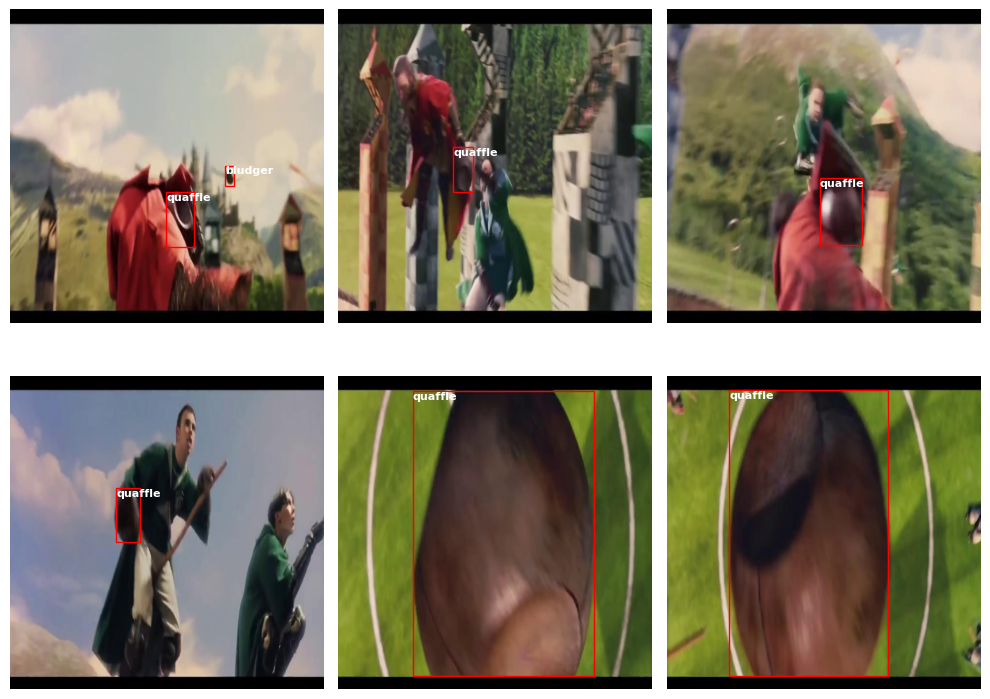

In [7]:
out = [train_ds[i] for i in range(6)]
visualize([o["image"] for o in out], [o["bboxes"] for o in out])

# Задача 3. 3 балла.
## YOLO

Сейчас нам предстоить реализовать YOLO детектор. Это один из самых простых детекторов с точки зрения реализации. Он описан в статье: [You Only Look Once: Unified, Real-Time Object Detection](https://arxiv.org/abs/1506.02640). Мы будем использовать ResNet для извлечения признаков. На выходе мы будем получать карту признаков размера 16x16. В каждом пикселе мы будем предсказывать размеры прямоугольника и класс.



We convert lists of bounding boxes to the target downsampled grid. For this we

* compute centers of bounding boxes ($c_x, c_y$)
* change center coordinates (offset from the top left corner for each corresponding grid cell on a small grid)
* normalize box height and with to $[0, 1]$
* fill the target grid with values

## Задача 3.1. 1 балл.

Первым делом нам нужно реализовать collate function. Это функция позволит нам кастомизировать, как именно батч конструируется из примеров (смотрите [pytorch docs](https://pytorch.org/docs/stable/data.html#dataloader-collate-fn) для деталей).

Это функция должна принять на вход лист прямоугольников и сгенерировать тензор размера Bx16x16x6. Первая размерность - это количество примеров в батче. Далее идут две пространственные размерности. В каналах у нас будут записаны координаты центра, центр относительно координат пикселя, бинарная переменная (детекция присутствует), класс детекции.

In [8]:
def collate_fn(batch: List[Dict[str, Any]],
               downsample: int = 32) -> Dict[str, Tensor]:
    """
    Функция объединения данных в батчи для DataLoader в PyTorch.

    :param batch: Список словарей, где каждый словарь содержит изображение и bounding boxes.
    :param downsample: Фактор понижения разрешения для целевой сетки.
    :return: Словарь с объединенными данными, включая изображения и тензор целевых значений.
    """
    imgs, batch_boxes = map(list, zip(*[(b["image"], b["bboxes"]) for b in batch]))

    imgs = torch.stack(imgs)
    b, _, h, w = imgs.shape

    target = imgs.new_zeros(b, 6, h // downsample, w // downsample)

    for i, boxes in enumerate(batch_boxes):
        for box in boxes:
            xmin, ymin, xmax, ymax, cls = box

            # Нормализация ширины и высоты
            w_box = (xmax - xmin) / w
            h_box = (ymax - ymin) / h

            # Расчет координат центра и сдвигов
            cx = (xmin + xmax) / 2
            cy = (ymin + ymax) / 2

            # Индекс клетки в сетке
            cx_idx = int(cx // downsample)
            cy_idx = int(cy // downsample)

            # Сдвиги относительно центра клетки
            cx_box = (cx - cx_idx * downsample) / downsample
            cy_box = (cy - cy_idx * downsample) / downsample

            target[i, :, cy_idx, cx_idx] = torch.tensor([cx_box, cy_box, w_box, h_box, 1, cls])

    return {"image": imgs, "target": target}

Ниже вы можете увидеть пример, как выглядит решетка размера 16 на 16 на исходном изображении:

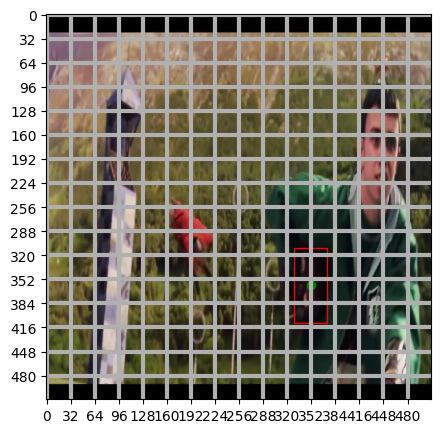

In [9]:
fig, ax = plt.subplots(figsize=(5, 5))
i = 20

img = train_ds[i]["image"].permute(1, 2, 0) * torch.tensor(std).view(
    1, 1, -1
) + torch.tensor(mean).view(1, 1, -1)
bboxes = torch.tensor(train_ds[i]["bboxes"])

ax.imshow(img)
loc = plt.matplotlib.ticker.MultipleLocator(base=32)
ax.xaxis.set_major_locator(loc)
ax.yaxis.set_major_locator(loc)
ax.grid(which="major", axis="both", linestyle="-", linewidth=3)

for bbox in bboxes:
    xmin, ymin, xmax, ymax = bbox[:-1]
    w = xmax - xmin
    h = ymax - ymin
    with_mask = bbox[-1]
    ax.add_patch(Rectangle((xmin, ymin), w, h, fill=False, color="red"))

cx = (bboxes[:, 0] + bboxes[:, 2]) / 2
cy = (bboxes[:, 1] + bboxes[:, 3]) / 2

ax.scatter(cx, cy, color="green", marker="o")

plt.show()

## Задача 3.2. 0.5 балла.

Реализуйте аналогичные принципы, чтобы декодировать выход нейронной сети. Применив функцию decode_prediction к выходу collate function вы должны получить изначальный набор прямоугольников с корректными размерами и координатами.

То есть, нужно проделать операции из collate_fn в обратную сторону.

In [10]:
def decode_prediction(preds: torch.Tensor,
                      upsample: int = 32,
                      threshold: float = 0.7) -> List[List[tuple]]:
    """
    Декодирование предсказаний модели.

    :param preds: Тензор с предсказаниями модели.
    :param upsample: Фактор увеличения разрешения для декодирования.
    :param threshold: Порог для определения объектов на изображении.
    :return: Список списков кортежей с координатами bounding boxes и классами объектов.
    """
    b, c, h, w = preds.shape
    img_w, img_h = w * upsample, h * upsample
    output = []
    for i in range(len(preds)):
        boxes = []
        pred = preds[i]
        mask = (pred[4] > threshold).long()
        pred[4, :, :] = mask
        for y in range(pred[4].shape[0]):
            for x in range(pred[4].shape[1]):
                if pred[4][y][x] == 1.:
                    center_x = upsample * (x + pred[0][y][x])
                    center_y = upsample * (y + pred[1][y][x])

                    x_min = center_x - (pred[2][y][x] * 512) / 2
                    x_max = center_x + (pred[2][y][x] * 512) / 2

                    y_min = center_y - (pred[3][y][x] * 512) / 2
                    y_max = center_y + (pred[3][y][x] * 512) / 2

                    if c == 6:
                        cls_pred = pred[5][y][x]
                    else:
                        cls_pred = torch.argmax((pred[:, y, x][5:]))
                    boxes.append(tuple([x_min.item(), y_min.item(), x_max.item(),
                                        y_max.item(),cls_pred.item() ]))
        output.append(boxes)

    return output

## Задача 3.3. 1 балл.
Реализуйте модель. Первым делом примените первые 4 блока (до layer4 вклюяительно) ResNet50. Далее добавьте несколько блоков (Conv2D, BatchNorm2D, ReLU). Постепенно уменьшайте количество каналов до 5+C, а размер изображения до 16 на 16. Например, 2048 -> 512 -> 128 -> 32 -> 5+C, где С - количество классов в вашем датасете. Размер ядра при этом 3, паддинг 1. Но вариантов много, попробуйте разные! **Последним слоем обязательно должна быть свертка.** Так как все значения, которые мы предсказываем, находятся в отрезке от 0 до 1 (благодаря нормировке с клеточками), мы после финальной свертки еще применим сигмоиду. Для классов в такой постановке это не навредит.

Если будете фантазировать, то для получения правильного размера изображения после сети не стесняйтесь применять слои с фильтрами больше 3.

In [11]:
import torch
import torch.nn as nn
from torchvision.models import resnet50, ResNet50_Weights


class Detector(nn.Module):
    def __init__(self, num_classes=3):
        """
        Инициализация модели детектора объектов.

        :param num_classes: Количество классов для предсказания (по умолчанию 3).
        """
        super().__init__()
        resnet = resnet50(weights=ResNet50_Weights.DEFAULT)
        self.feature_extractor = nn.Sequential(*list(resnet.children())[:8])  # Берем первые 4 блока

        # Добавляем слои Dropout для регуляризации
        self.dropout = nn.Dropout(p=0.5)

        # Обновляем сверточные слои
        self.conv_layers = nn.Sequential(
            nn.Conv2d(2048, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 5 + num_classes, kernel_size=3, padding=1)  # Финальный слой для предсказания
        )

    def forward(self, img):
        """
        Инициализация модели детектора объектов.

        :param num_classes: Количество классов для предсказания (по умолчанию 3).
        """
        x = self.feature_extractor(img)
        x = self.dropout(x)  # Применяем Dropout
        x = self.conv_layers(x)
        return torch.sigmoid(x)


C = 3


## Задача 3.4. 0.5 балла.

Реализуйте функцию потерь.

Для этого:
* Сделайте маску, которая будет говорить о положении детектируемых объектов. Её нужно использовать с помощью masked_select (см. доки PyTorch)
* Лосс похож на оригинальный для Yolo V1 и состоит из 4 частей (reduction='sum' для всех)
    - localization loss - Мы берем MSE по координатам бокса там, где есть детектируемый объект
    - box_loss - MSE от корней ширины и высоты
    - classification_loss - Если детектируемый объект есть, то его кросс-энтропия по его классу
    - confidence_loss - Бинарная кросс-энтропия факта наличия объекта ДЛЯ ВСЕХ пикселей. Делается отдельно для детектируемых объектов (вес 1) и для недетектируемых (вес 0.1 например, поскольку их гораздо больше, но можно экспериментировать)

* Ниже есть assert. Если вы экспериментируете с лоссом, он не будет проходить, не обращайте на него внимание. Если будете делать описанное выше, то учтите reduction. Бинарная кросс-энтропия вызывается через BCELoss. Параметр C используется для задачи числа классов. assert написан для 3 классов, в задаче с картами их 6. Подумайте как зависит индексация от параметра C и используйте его.

In [3]:
import torch.nn.functional as F

def special_loss(pred, target, C=3, check=False):
    """
    Рассчет сложной функции потерь для задачи детекции объектов.

    :param pred: Тензор с предсказаниями модели.
    :param target: Тензор с целевыми данными (ground truth).
    :param C: Количество классов (по умолчанию 3).
    :param check: Флаг, указывающий на возвращение отдельных компонентов функции потерь (опционально).
    :return: Значение функции потерь или компоненты (если check=True).
    """
    mask = target[:, 4, :, :] > 0.5

    # Localization Loss
    localization_loss = F.mse_loss(
        torch.masked_select(pred[:, :2, :, :], mask.unsqueeze(1)),
        torch.masked_select(target[:, :2, :, :], mask.unsqueeze(1)),
        reduction='sum'
    )

    # Box Loss
    box_loss = F.mse_loss(
        torch.sqrt(torch.masked_select(pred[:, 2:4, :, :], mask.unsqueeze(1))),
        torch.sqrt(torch.masked_select(target[:, 2:4, :, :], mask.unsqueeze(1))),
        reduction='sum'
    )

    # Classification Loss
    indices = torch.nonzero(mask, as_tuple=True)
    class_pred = pred[indices[0], 5:5+C, indices[1], indices[2]]
    class_target = target[indices[0], 5, indices[1], indices[2]]
    class_pred = class_pred.view(-1, C)
    class_target = class_target.view(-1)
    class_target = class_target.long() % C
    classification_loss = F.cross_entropy(class_pred, class_target, reduction='sum')

    # Confidence Loss
    confidence_loss = F.binary_cross_entropy(pred[:, 4, :, :], target[:, 4, :, :], reduction='sum')

    if check:
        return localization_loss, box_loss, classification_loss, confidence_loss
    else:
        return localization_loss + box_loss + classification_loss + confidence_loss

In [13]:
# localization box classification confidence - возвращаются в таком порядке, можно сравнить
assert special_loss(torch.zeros((10, 8, 16, 16)),
                    torch.ones((10, 8, 16, 16)),
                    check=True, C=3) == (torch.tensor(5120.),
                                         torch.tensor(5120.),
                                         torch.tensor(2812.4465),
                                         torch.tensor(256000.))

# Задача 4. 2 балла.

Обучите вашу модель (написав цикл обучения), и покажите что она работает (скорее всего, объекты найдутся на 1-2 картинках).

In [14]:
loader = torch.utils.data.DataLoader(train_ds, 10, collate_fn=collate_fn)

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.manual_seed(21)
EPOCHS = 25 # Harry Potter 20, Cards 15
model = Detector().to(device)
opt = torch.optim.AdamW(model.parameters(), lr=1e-3)

for e in range(EPOCHS):
    model.train()  # Переключение модели в режим обучения
    epoch_losses = []

    for batch in tqdm(loader, leave=False):
        imgs = batch['image'].to(device)
        targets = batch['target'].to(device)

        # Обнуляем градиенты оптимизатора
        opt.zero_grad()

        # Прямое распространение
        preds = model(imgs)

        # Расчет функции потерь
        loss = special_loss(preds, targets)

        # Обратное распространение ошибки
        loss.backward()

        # Обновление весов модели
        opt.step()

        # Сохранение значений потерь для вывода статистики
        epoch_losses.append(loss.item())

    print(f"Epoch {e} done; Train loss {np.mean(epoch_losses):.3f};")

  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 0 done; Train loss 700.181;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 1 done; Train loss 142.496;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 2 done; Train loss 82.858;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 3 done; Train loss 55.643;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 4 done; Train loss 42.130;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 5 done; Train loss 37.837;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 6 done; Train loss 33.259;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 7 done; Train loss 26.251;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 8 done; Train loss 22.266;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 9 done; Train loss 19.634;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 10 done; Train loss 17.661;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 11 done; Train loss 16.009;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 12 done; Train loss 16.155;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 13 done; Train loss 20.588;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 14 done; Train loss 22.625;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 15 done; Train loss 16.492;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 16 done; Train loss 13.286;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 17 done; Train loss 11.408;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 18 done; Train loss 10.066;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 19 done; Train loss 9.557;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 20 done; Train loss 8.799;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 21 done; Train loss 8.435;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 22 done; Train loss 8.464;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 23 done; Train loss 8.131;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 24 done; Train loss 8.020;


Запустим обученный детектор на тестовых изображениях:

In [16]:
test_loader = torch.utils.data.DataLoader(test_ds, 6, collate_fn=collate_fn)
i = iter(test_loader)
batch = next(i)

In [17]:
# Выполнение предсказания
preds = model(batch['image'].to(device))

# Декодирование предсказаний
decoded_preds = decode_prediction(preds, threshold=0.7)

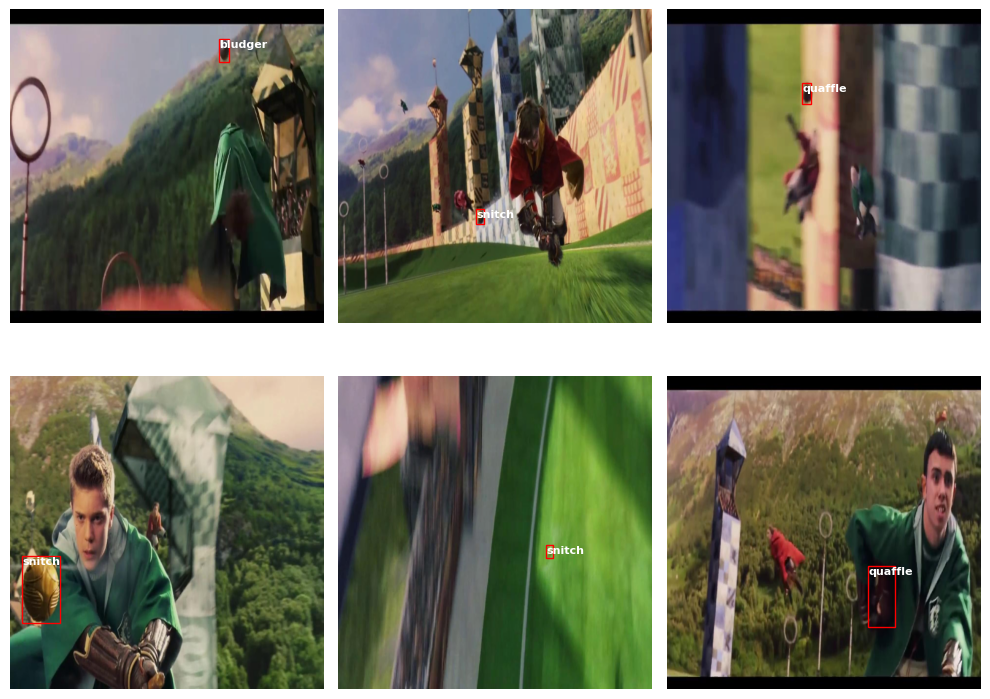

In [18]:
visualize([image for image in batch['image']], decoded_preds)

Результат сильно так себе, да? Есть множество вариантов улучшений, самый простой из которых это приделать к выходу [NMS](https://paperswithcode.com/method/non-maximum-suppression#:~:text=Non%20Maximum%20Suppression%20is%20a,below%20a%20given%20probability%20bound.). Если хочется, можно почитать про YOLO v1 [тут](https://arxiv.org/abs/1506.02640).

# Задача 5. 3.5 балла.

Займёмся более простыми вещами. Возьмем готовую архитектуру, обучим её на наших данных и посмотрим.

Для этого будем использовать YOLO v8 от ultralytics.

## Задача 5.1. 1.5 балла.

Чтобы дальше модель обучалась одной строкой, данные нужно переложить в правильный формат. Да-да, классика перекладывания JSON. Как правильно паковать можно посмотреть [тут](https://roboflow.com/formats/yolov8-pytorch-txt).

Если коротко:
* Есть .yaml, где живут пути к папкам с картинками, количество классов и их названия
* Есть папочки train valid (их поможем вам собрать), в них две подпапки:
    - Первая images, в ней лежат картинки
    - Вторая labels, в ней лежат файлы с названиями как у картинок, но вместо расширения картинок нужен .txt, внутри формат как описан на Roboflow


In [20]:
# Делаем папочки
!rm -rf train
!rm -rf valid
!mkdir -p train/images train/labels valid/images valid/labels

Реализуйте функцию, которая принимает аннотации в изначальном формате, а возвращает их в нужном для YOLO v8. Это должен быть массив готовых строк, которые можно сразу забрасывать в файлик, добавив \n.

In [4]:
def annotation2txt(bboxes, w_im, h_im):
    """
    Преобразование аннотаций bounding boxes в текстовый формат.

    :param bboxes: Список bounding boxes с координатами и классами.
    :param w_im: Ширина изображения.
    :param h_im: Высота изображения.
    :return: Список строк с аннотациями в текстовом формате.
    """
    strs = []
    for box in bboxes:
        class_id = box[4]
        center_x = (box[0] + box[2]) / 2 / w_im
        center_y = (box[1] + box[3]) / 2 / h_im
        width = (box[2] - box[0]) / w_im
        height = (box[3] - box[1]) / h_im
        strs.append(" ".join([str(class_id), str(center_x), str(center_y), str(width), str(height)]))
    return strs

In [22]:
# Копируем картиночки по папочкам и создаем txt файлики

for i in range(len(train_ds)):
    result = train_ds.__get_raw_item__(i)

    shutil.copyfile(
        result[0], "./train/images/" + result[0].split("/")[-1],
    )

    h_im, w_im, ch = np.array(Image.open(result[0])).shape
    with open(
        "./train/labels/" + result[0].split("/")[-1].split(".")[0] + ".txt",
        "w",
        encoding="utf8",
    ) as f:
        f.write("\n".join(annotation2txt(result[1], w_im, h_im)))

for i in range(len(test_ds)):
    result = test_ds.__get_raw_item__(i)

    shutil.copyfile(
        result[0], "./valid/images/" + result[0].split("/")[-1],
    )

    with open(
        "./valid/labels/" + result[0].split("/")[-1].split(".")[0] + ".txt",
        "w",
        encoding="utf8",
    ) as f:
        f.write("\n".join(annotation2txt(result[1], w_im, h_im)))

In [24]:
# Собираем YAML
class_dict = {"snitch": 0, "quaffle": 1, "bludger": 2}
nc = max(class_dict.values()) + 1
names = list(class_dict.keys())

with open("data.yaml", "w") as f:
    f.write(f"train: ../train/images\nval: ../valid/images\n\nnc: {nc}\nnames: {names}")

## Задание 5.2. 1.5 балла.

Обучите модель YOLO v8 самого маленького размера. Библиотека максимально friendly, от вас требуется написать две строчки. Модель нужно взять необученную!

Подсказка: подумайте зачем вам data.yaml и что такое yolov8n.yaml (не стесняйтесь гуглить)

In [25]:
from ultralytics import YOLO

model = YOLO('yolov8n.yaml')
results = model.train(data='data.yaml', epochs=250)


                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128

train: Scanning /content/train/labels... 254 images, 0 backgrounds, 0 corrupt: 100%|██████████| 254/254 [00:00<00:00, 2115.81it/s]

train: New cache created: /content/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/valid/labels... 29 images, 0 backgrounds, 0 corrupt: 100%|██████████| 29/29 [00:00<00:00, 837.66it/s]


val: New cache created: /content/valid/labels.cache
Plotting labels to runs/detect/train2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train2
Starting training for 250 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/250       5.8G       5.27      11.59      4.218         35        640: 100%|██████████| 16/16 [00:07<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.34it/s]

                   all         29         33   5.42e-05     0.0417   4.07e-05   4.07e-06



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/250      5.55G      4.534      8.091      4.155         27        640: 100%|██████████| 16/16 [00:06<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.04it/s]

                   all         29         33    0.00011     0.0417   7.26e-05   7.26e-06



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/250      5.55G      4.138      7.579      3.894         31        640: 100%|██████████| 16/16 [00:04<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.55it/s]

                   all         29         33    0.00011     0.0417   7.26e-05   7.26e-06



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/250      5.55G       3.53      6.554      3.531         23        640: 100%|██████████| 16/16 [00:06<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.64it/s]

                   all         29         33    0.00011     0.0417   7.26e-05   7.26e-06



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/250      5.55G       3.45      6.301      3.329         24        640: 100%|██████████| 16/16 [00:04<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.91it/s]

                   all         29         33    0.00011     0.0417   7.26e-05   7.26e-06



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/250      5.55G      3.076      5.602      3.072         31        640: 100%|██████████| 16/16 [00:06<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.20it/s]

                   all         29         33    0.00011     0.0417   7.26e-05   7.26e-06



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/250      5.55G      2.962      5.186      2.808         36        640: 100%|██████████| 16/16 [00:04<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.14it/s]

                   all         29         33   0.000294     0.0238   0.000159   7.95e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/250      5.55G      2.834      5.006       2.69         33        640: 100%|██████████| 16/16 [00:06<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.03it/s]

                   all         29         33   0.000669      0.167    0.00096     0.0003



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/250      5.55G      2.868      5.156      2.608         28        640: 100%|██████████| 16/16 [00:04<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.32it/s]

                   all         29         33   0.000777      0.197    0.00126   0.000498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/250      5.55G      2.671       4.52      2.434         30        640: 100%|██████████| 16/16 [00:06<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.37it/s]

                   all         29         33      0.867     0.0476     0.0887     0.0501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/250      5.55G      2.595      4.284      2.308         32        640: 100%|██████████| 16/16 [00:04<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.20it/s]

                   all         29         33      0.135     0.0714     0.0775     0.0451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/250      5.55G      2.523      4.082      2.236         28        640: 100%|██████████| 16/16 [00:06<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.42it/s]

                   all         29         33      0.836     0.0714      0.114     0.0523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/250      5.55G      2.528      3.833      2.298         37        640: 100%|██████████| 16/16 [00:04<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.44it/s]

                   all         29         33      0.864     0.0779      0.109     0.0412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/250      5.55G      2.482      3.527      2.221         33        640: 100%|██████████| 16/16 [00:06<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.11it/s]

                   all         29         33      0.833      0.102      0.103     0.0442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/250      5.55G      2.258      3.384      2.006         31        640: 100%|██████████| 16/16 [00:04<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.89it/s]

                   all         29         33      0.814      0.102      0.127     0.0675



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/250      5.55G      2.267      3.219      1.975         24        640: 100%|██████████| 16/16 [00:05<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]

                   all         29         33      0.626     0.0757     0.0822     0.0444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/250      5.55G      2.202      3.015      1.951         22        640: 100%|██████████| 16/16 [00:04<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.48it/s]

                   all         29         33      0.287      0.143      0.107     0.0577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/250      5.57G      2.234      3.148      2.004         34        640: 100%|██████████| 16/16 [00:05<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]

                   all         29         33      0.272      0.126       0.13      0.054



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/250      5.57G       2.22      2.933      1.986         31        640: 100%|██████████| 16/16 [00:04<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.50it/s]

                   all         29         33      0.248      0.209      0.149     0.0828



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/250      5.55G      2.241      2.924      1.917         28        640: 100%|██████████| 16/16 [00:05<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]

                   all         29         33      0.377      0.146      0.178       0.09



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/250      5.55G      2.081      2.694        1.8         30        640: 100%|██████████| 16/16 [00:04<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.48it/s]

                   all         29         33      0.303      0.149      0.138     0.0518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/250      5.55G      2.111      2.679      1.837         24        640: 100%|██████████| 16/16 [00:04<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.48it/s]

                   all         29         33      0.353      0.233      0.204      0.114



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/250      5.57G      1.988       2.52      1.726         28        640: 100%|██████████| 16/16 [00:05<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.64it/s]

                   all         29         33      0.361      0.196      0.238      0.113



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/250      5.55G      1.951      2.468      1.713         36        640: 100%|██████████| 16/16 [00:04<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.68it/s]

                   all         29         33      0.549      0.191       0.24      0.122



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/250      5.57G      1.948      2.306      1.713         35        640: 100%|██████████| 16/16 [00:05<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.44it/s]

                   all         29         33      0.336      0.143      0.186     0.0956



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/250      5.55G      2.093      2.499      1.774         35        640: 100%|██████████| 16/16 [00:04<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.63it/s]

                   all         29         33      0.305      0.208      0.183     0.0989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/250      5.55G      2.013      2.253      1.736         32        640: 100%|██████████| 16/16 [00:05<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.45it/s]

                   all         29         33      0.708      0.191      0.208      0.118



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/250      5.57G      1.888      2.238      1.684         22        640: 100%|██████████| 16/16 [00:04<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.03it/s]

                   all         29         33      0.371      0.204      0.221      0.135



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/250      5.55G      1.936      2.233      1.671         26        640: 100%|██████████| 16/16 [00:05<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.38it/s]

                   all         29         33      0.339      0.256      0.225      0.132



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/250      5.55G      1.963      2.218      1.644         22        640: 100%|██████████| 16/16 [00:05<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.59it/s]

                   all         29         33      0.574      0.215      0.229      0.109



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/250      5.55G       1.95       2.11      1.641         38        640: 100%|██████████| 16/16 [00:06<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.32it/s]

                   all         29         33      0.365      0.197       0.17     0.0749



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/250      5.55G      1.878      2.149      1.598         25        640: 100%|██████████| 16/16 [00:04<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.42it/s]

                   all         29         33      0.426      0.304      0.316       0.15



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/250      5.55G      1.883      2.096      1.612         28        640: 100%|██████████| 16/16 [00:06<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.52it/s]

                   all         29         33      0.536       0.23      0.267      0.148



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/250      5.55G      1.735      1.977      1.575         22        640: 100%|██████████| 16/16 [00:04<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.62it/s]

                   all         29         33      0.507      0.303       0.33      0.173



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/250      5.57G      1.805      1.896      1.538         32        640: 100%|██████████| 16/16 [00:06<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.14it/s]

                   all         29         33      0.376      0.302      0.292      0.149



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/250      5.55G       1.77      1.963      1.521         28        640: 100%|██████████| 16/16 [00:04<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

                   all         29         33      0.434      0.268      0.318      0.163



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/250      5.55G      1.747      1.902      1.487         31        640: 100%|██████████| 16/16 [00:06<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.15it/s]

                   all         29         33      0.387      0.328      0.317      0.141



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/250      5.57G      1.664      1.856      1.528         22        640: 100%|██████████| 16/16 [00:04<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.79it/s]

                   all         29         33      0.539      0.262      0.321      0.147



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/250      5.57G      1.779      1.863      1.541         31        640: 100%|██████████| 16/16 [00:06<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.65it/s]

                   all         29         33      0.422      0.306      0.312      0.145



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/250      5.55G      1.735      1.781      1.535         35        640: 100%|██████████| 16/16 [00:04<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.46it/s]

                   all         29         33      0.308      0.304      0.258      0.129



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/250      5.55G       1.69      1.756      1.488         18        640: 100%|██████████| 16/16 [00:05<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.69it/s]

                   all         29         33      0.366       0.31      0.305      0.141



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/250      5.55G       1.61      1.662      1.408         32        640: 100%|██████████| 16/16 [00:04<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.13it/s]

                   all         29         33      0.537      0.328      0.353      0.181



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/250      5.55G      1.662      1.674      1.477         32        640: 100%|██████████| 16/16 [00:05<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.58it/s]

                   all         29         33      0.312       0.28      0.269      0.129



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/250      5.55G      1.652      1.724      1.466         28        640: 100%|██████████| 16/16 [00:04<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.48it/s]

                   all         29         33       0.51      0.304      0.336      0.178



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/250      5.55G      1.638      1.655      1.452         26        640: 100%|██████████| 16/16 [00:04<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.59it/s]

                   all         29         33      0.508      0.274      0.367      0.193



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/250      5.55G      1.682      1.718      1.489         41        640: 100%|██████████| 16/16 [00:05<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.17it/s]

                   all         29         33      0.521      0.328      0.386      0.188



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/250      5.55G      1.674      1.683      1.477         24        640: 100%|██████████| 16/16 [00:04<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.65it/s]

                   all         29         33      0.414       0.38      0.349       0.19



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/250      5.55G      1.577      1.596      1.376         24        640: 100%|██████████| 16/16 [00:05<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.15it/s]

                   all         29         33      0.358      0.405      0.358       0.19



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/250      5.55G      1.607      1.539      1.418         34        640: 100%|██████████| 16/16 [00:04<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.70it/s]

                   all         29         33      0.402      0.308       0.35      0.166



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/250      5.55G      1.606      1.551      1.442         32        640: 100%|██████████| 16/16 [00:06<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.32it/s]

                   all         29         33      0.483      0.393      0.381      0.195



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/250      5.55G      1.567      1.496      1.439         24        640: 100%|██████████| 16/16 [00:04<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.37it/s]

                   all         29         33      0.445      0.393      0.374       0.21



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/250      5.55G      1.509      1.432      1.341         27        640: 100%|██████████| 16/16 [00:08<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.21it/s]

                   all         29         33      0.553      0.323      0.388      0.199



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/250      5.55G      1.515      1.459      1.365         31        640: 100%|██████████| 16/16 [00:04<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.80it/s]

                   all         29         33      0.364      0.326      0.334      0.183



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/250      5.55G      1.535      1.445      1.364         25        640: 100%|██████████| 16/16 [00:05<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.69it/s]

                   all         29         33       0.49      0.393      0.393      0.233



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/250      5.55G      1.484      1.347      1.323         29        640: 100%|██████████| 16/16 [00:04<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.39it/s]

                   all         29         33      0.533      0.352      0.411      0.229



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/250      5.55G      1.518      1.384      1.342         20        640: 100%|██████████| 16/16 [00:05<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.71it/s]

                   all         29         33      0.667      0.262      0.374      0.218



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/250      5.55G      1.507      1.425      1.344         26        640: 100%|██████████| 16/16 [00:04<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.49it/s]

                   all         29         33      0.515       0.37       0.38      0.212



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/250      5.55G      1.504       1.36      1.375         21        640: 100%|██████████| 16/16 [00:04<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.69it/s]

                   all         29         33      0.643      0.328      0.423      0.239



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/250      5.55G      1.476      1.319      1.333         33        640: 100%|██████████| 16/16 [00:05<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.75it/s]

                   all         29         33      0.717        0.3      0.406      0.236



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/250      5.55G      1.415      1.236      1.283         30        640: 100%|██████████| 16/16 [00:04<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.66it/s]

                   all         29         33      0.697      0.327      0.391      0.216



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/250      5.57G      1.378      1.233      1.305         32        640: 100%|██████████| 16/16 [00:05<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.49it/s]

                   all         29         33      0.528      0.381      0.415      0.241



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/250      5.55G      1.478      1.276      1.342         37        640: 100%|██████████| 16/16 [00:04<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.30it/s]

                   all         29         33      0.499      0.393      0.392      0.219



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/250      5.55G      1.429      1.239      1.349         27        640: 100%|██████████| 16/16 [00:06<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.67it/s]

                   all         29         33      0.676      0.346      0.481       0.25



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/250      5.55G        1.4      1.239      1.272         34        640: 100%|██████████| 16/16 [00:04<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.89it/s]

                   all         29         33      0.586       0.37      0.446      0.262



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/250      5.57G      1.494      1.238      1.366         31        640: 100%|██████████| 16/16 [00:06<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.98it/s]

                   all         29         33      0.676      0.352       0.44      0.252



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/250      5.55G      1.428      1.224      1.337         34        640: 100%|██████████| 16/16 [00:04<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.03it/s]

                   all         29         33      0.573      0.386      0.432      0.242



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/250      5.55G      1.408      1.185      1.263         26        640: 100%|██████████| 16/16 [00:06<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.35it/s]

                   all         29         33      0.743      0.345      0.449      0.234



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/250      5.55G      1.459      1.253      1.336         23        640: 100%|██████████| 16/16 [00:04<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.72it/s]

                   all         29         33      0.533      0.417      0.414      0.246



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/250      5.55G      1.345      1.121       1.24         30        640: 100%|██████████| 16/16 [00:06<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.02it/s]

                   all         29         33       0.55       0.37       0.41      0.233



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/250      5.55G      1.462       1.25       1.29         38        640: 100%|██████████| 16/16 [00:04<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.41it/s]

                   all         29         33      0.441       0.37      0.428      0.253



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/250      5.55G      1.416      1.197      1.285         26        640: 100%|██████████| 16/16 [00:06<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.56it/s]

                   all         29         33      0.626      0.374      0.454      0.284



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/250      5.55G      1.414      1.251      1.322         30        640: 100%|██████████| 16/16 [00:04<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.60it/s]

                   all         29         33      0.555       0.37      0.422      0.207



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/250      5.55G      1.379      1.109      1.245         29        640: 100%|██████████| 16/16 [00:05<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.63it/s]

                   all         29         33      0.602      0.385      0.451      0.274



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/250      5.55G      1.357      1.131       1.29         24        640: 100%|██████████| 16/16 [00:04<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.53it/s]

                   all         29         33      0.486      0.447      0.462      0.258



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/250      5.55G      1.392      1.107       1.29         26        640: 100%|██████████| 16/16 [00:05<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]

                   all         29         33      0.592      0.393      0.473       0.28



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/250      5.55G      1.375      1.115      1.284         24        640: 100%|██████████| 16/16 [00:04<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.32it/s]

                   all         29         33      0.614      0.386       0.45       0.27



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/250      5.55G       1.27      1.049      1.258         27        640: 100%|██████████| 16/16 [00:04<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.60it/s]

                   all         29         33      0.596      0.393      0.423      0.218



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/250      5.55G      1.307      1.106      1.228         25        640: 100%|██████████| 16/16 [00:05<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.44it/s]

                   all         29         33      0.444      0.441      0.459      0.254



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/250      5.55G      1.381      1.109      1.243         34        640: 100%|██████████| 16/16 [00:04<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.49it/s]

                   all         29         33      0.585      0.393      0.426      0.241



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/250      5.55G        1.3      1.118      1.228         33        640: 100%|██████████| 16/16 [00:05<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.40it/s]

                   all         29         33      0.523      0.477      0.464      0.263



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/250      5.55G      1.297      1.032      1.216         33        640: 100%|██████████| 16/16 [00:04<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.65it/s]

                   all         29         33      0.631      0.417      0.496      0.275



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/250      5.55G      1.351      1.128      1.244         23        640: 100%|██████████| 16/16 [00:06<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.35it/s]

                   all         29         33      0.505      0.376      0.432      0.245



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/250      5.55G      1.315      1.095      1.275         35        640: 100%|██████████| 16/16 [00:04<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.66it/s]

                   all         29         33      0.636      0.412      0.517       0.29



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/250      5.55G      1.255      1.084      1.206         30        640: 100%|██████████| 16/16 [00:06<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.23it/s]

                   all         29         33       0.62      0.395      0.507      0.267



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/250      5.55G      1.317      1.047      1.211         31        640: 100%|██████████| 16/16 [00:04<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.45it/s]

                   all         29         33      0.569      0.459      0.472      0.268



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/250      5.55G      1.293      1.025      1.199         29        640: 100%|██████████| 16/16 [00:06<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.11it/s]

                   all         29         33      0.522      0.514      0.475      0.285



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/250      5.55G      1.354      1.044      1.249         27        640: 100%|██████████| 16/16 [00:04<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.43it/s]

                   all         29         33      0.507      0.523      0.509      0.282



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/250      5.56G      1.278      1.036      1.251         21        640: 100%|██████████| 16/16 [00:05<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.56it/s]

                   all         29         33      0.628      0.438      0.505      0.283



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/250      5.55G      1.264      1.007      1.227         28        640: 100%|██████████| 16/16 [00:04<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.66it/s]

                   all         29         33      0.572      0.441      0.487      0.299



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/250      5.55G       1.26      1.017      1.207         26        640: 100%|██████████| 16/16 [00:05<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.04it/s]

                   all         29         33      0.692      0.416      0.476      0.273



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/250      5.55G      1.272      0.992      1.222         30        640: 100%|██████████| 16/16 [00:04<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.62it/s]

                   all         29         33      0.627      0.434      0.489      0.303



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/250      5.55G       1.25     0.9605       1.19         30        640: 100%|██████████| 16/16 [00:04<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.71it/s]

                   all         29         33      0.525      0.378      0.415      0.261



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/250      5.57G      1.169     0.9786      1.147         30        640: 100%|██████████| 16/16 [00:05<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.36it/s]

                   all         29         33      0.571      0.441      0.482      0.283



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/250      5.55G      1.185     0.9589      1.193         29        640: 100%|██████████| 16/16 [00:04<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.54it/s]

                   all         29         33      0.444      0.524      0.455      0.251



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/250      5.55G      1.205     0.9762       1.18         34        640: 100%|██████████| 16/16 [00:05<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.38it/s]

                   all         29         33      0.559      0.393       0.48      0.285



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/250      5.55G      1.199     0.9272      1.166         31        640: 100%|██████████| 16/16 [00:04<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.27it/s]

                   all         29         33      0.566      0.393      0.482      0.267



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/250      5.55G      1.211      0.946      1.153         36        640: 100%|██████████| 16/16 [00:06<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]

                   all         29         33      0.593      0.417      0.504      0.269



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/250      5.55G      1.241      0.976      1.223         29        640: 100%|██████████| 16/16 [00:04<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.61it/s]

                   all         29         33      0.572      0.439      0.496      0.277



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/250      5.57G      1.291     0.9543      1.222         30        640: 100%|██████████| 16/16 [00:06<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.37it/s]

                   all         29         33      0.514      0.441      0.483      0.262



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/250      5.55G      1.245     0.9588      1.205         29        640: 100%|██████████| 16/16 [00:04<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.63it/s]

                   all         29         33      0.535      0.441      0.478      0.289



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/250      5.55G      1.214     0.9207      1.183         27        640: 100%|██████████| 16/16 [00:06<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.19it/s]

                   all         29         33      0.522      0.476      0.489      0.292



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/250      5.55G      1.168     0.8858      1.174         26        640: 100%|██████████| 16/16 [00:04<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.93it/s]

                   all         29         33       0.54      0.477      0.505      0.285



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/250      5.55G      1.186     0.8829      1.162         37        640: 100%|██████████| 16/16 [00:06<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.42it/s]

                   all         29         33      0.626      0.417       0.44      0.266



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/250      5.55G      1.184     0.8897      1.145         25        640: 100%|██████████| 16/16 [00:04<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.50it/s]

                   all         29         33      0.562      0.441      0.457      0.281



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/250      5.55G      1.204     0.9077      1.184         24        640: 100%|██████████| 16/16 [00:06<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.59it/s]

                   all         29         33      0.601       0.41      0.482      0.302



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/250      5.55G       1.24     0.8908      1.175         26        640: 100%|██████████| 16/16 [00:04<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.99it/s]

                   all         29         33      0.603      0.441      0.492      0.291



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/250      5.55G      1.217     0.8668      1.215         31        640: 100%|██████████| 16/16 [00:05<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.94it/s]

                   all         29         33       0.58       0.47      0.513      0.293



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/250      5.55G      1.182     0.8751      1.199         32        640: 100%|██████████| 16/16 [00:04<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.76it/s]

                   all         29         33      0.623      0.421      0.516      0.292



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/250      5.55G      1.211     0.8603      1.149         27        640: 100%|██████████| 16/16 [00:05<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

                   all         29         33       0.68      0.417      0.502      0.315



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/250      5.55G      1.193      0.898      1.178         41        640: 100%|██████████| 16/16 [00:04<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.60it/s]

                   all         29         33      0.607      0.479      0.506      0.303



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/250      5.55G      1.174     0.8302      1.157         34        640: 100%|██████████| 16/16 [00:04<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.68it/s]

                   all         29         33      0.619      0.441      0.505      0.296



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/250      5.55G       1.19     0.8635      1.189         28        640: 100%|██████████| 16/16 [00:05<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.25it/s]

                   all         29         33      0.537      0.434      0.489      0.309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/250      5.55G      1.151     0.8099      1.137         34        640: 100%|██████████| 16/16 [00:04<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.55it/s]

                   all         29         33      0.572      0.441      0.466      0.285



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/250      5.55G       1.15     0.8733      1.149         24        640: 100%|██████████| 16/16 [00:05<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.93it/s]

                   all         29         33      0.586      0.441      0.486      0.299



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/250      5.55G       1.18     0.8452      1.172         24        640: 100%|██████████| 16/16 [00:04<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.32it/s]

                   all         29         33      0.556      0.417      0.499      0.278



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/250      5.55G       1.14     0.7731      1.078         32        640: 100%|██████████| 16/16 [00:06<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.54it/s]

                   all         29         33      0.501      0.489      0.485      0.268



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/250      5.55G      1.128     0.7808      1.104         34        640: 100%|██████████| 16/16 [00:04<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.54it/s]

                   all         29         33      0.502      0.512      0.507      0.301



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/250      5.55G      1.213     0.8011       1.14         35        640: 100%|██████████| 16/16 [00:06<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.58it/s]

                   all         29         33      0.522      0.477      0.478      0.267



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/250      5.55G      1.237     0.9097      1.206         26        640: 100%|██████████| 16/16 [00:04<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.06it/s]

                   all         29         33      0.617      0.447      0.513      0.307



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/250      5.55G      1.136     0.8259      1.155         23        640: 100%|██████████| 16/16 [00:06<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.57it/s]

                   all         29         33      0.558      0.504      0.537      0.322



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/250      5.57G      1.139     0.8257      1.163         36        640: 100%|██████████| 16/16 [00:04<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.55it/s]

                   all         29         33      0.574      0.417      0.491      0.275



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/250      5.57G      1.177     0.8595      1.139         40        640: 100%|██████████| 16/16 [00:06<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.50it/s]

                   all         29         33      0.644      0.433      0.492      0.283



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/250      5.55G      1.102     0.7884      1.118         29        640: 100%|██████████| 16/16 [00:04<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.28it/s]

                   all         29         33        0.6      0.417       0.47      0.289



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/250      5.57G      1.175     0.8277      1.155         27        640: 100%|██████████| 16/16 [00:05<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.82it/s]

                   all         29         33      0.522      0.453      0.507      0.285



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/250      5.55G      1.097     0.7514      1.146         32        640: 100%|██████████| 16/16 [00:04<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.77it/s]

                   all         29         33      0.618      0.412      0.515      0.291



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/250      5.55G      1.116     0.8165      1.105         33        640: 100%|██████████| 16/16 [00:05<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.62it/s]

                   all         29         33      0.525      0.524      0.515      0.289



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/250      5.55G      1.097     0.8175      1.127         34        640: 100%|██████████| 16/16 [00:04<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.17it/s]

                   all         29         33      0.577      0.553      0.533      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/250      5.55G      1.117     0.7951       1.13         35        640: 100%|██████████| 16/16 [00:04<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

                   all         29         33      0.604      0.441      0.527      0.306



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/250      5.55G      1.102     0.7913      1.112         24        640: 100%|██████████| 16/16 [00:07<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.60it/s]

                   all         29         33      0.519      0.516      0.528      0.305



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/250      5.57G      1.049     0.7566      1.077         30        640: 100%|██████████| 16/16 [00:05<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

                   all         29         33      0.453      0.517      0.491      0.268



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/250      5.55G      1.108     0.8028       1.13         29        640: 100%|██████████| 16/16 [00:04<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.28it/s]

                   all         29         33      0.576      0.408      0.492      0.283



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/250      5.55G      1.045     0.7409        1.1         30        640: 100%|██████████| 16/16 [00:05<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.64it/s]

                   all         29         33      0.526       0.48      0.503      0.303



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/250      5.55G      1.061     0.7674      1.132         27        640: 100%|██████████| 16/16 [00:04<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.20it/s]

                   all         29         33      0.485      0.506      0.475      0.287



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/250      5.55G      1.114     0.7657      1.102         36        640: 100%|██████████| 16/16 [00:04<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.81it/s]

                   all         29         33      0.467      0.524      0.479      0.268



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/250      5.55G      1.015     0.7448      1.062         29        640: 100%|██████████| 16/16 [00:05<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.51it/s]

                   all         29         33      0.574      0.417      0.475      0.249



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/250      5.55G      1.091     0.7552      1.102         32        640: 100%|██████████| 16/16 [00:04<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.98it/s]

                   all         29         33      0.499       0.47      0.512      0.272



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/250      5.55G       1.04     0.7527      1.101         25        640: 100%|██████████| 16/16 [00:05<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.23it/s]

                   all         29         33      0.569      0.524       0.53      0.318



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/250      5.55G      1.083     0.7369      1.097         24        640: 100%|██████████| 16/16 [00:04<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.28it/s]

                   all         29         33      0.613      0.393      0.529      0.295



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/250      5.57G      1.058     0.7331      1.097         40        640: 100%|██████████| 16/16 [00:06<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.57it/s]

                   all         29         33      0.504      0.441      0.476       0.27



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/250      5.55G       1.01     0.6782      1.049         32        640: 100%|██████████| 16/16 [00:04<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.45it/s]

                   all         29         33      0.549      0.437       0.47      0.263



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/250      5.55G      1.059     0.7574      1.116         22        640: 100%|██████████| 16/16 [00:06<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.43it/s]

                   all         29         33      0.695      0.393      0.506      0.314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/250      5.55G      1.022     0.7193      1.103         32        640: 100%|██████████| 16/16 [00:04<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.89it/s]

                   all         29         33      0.669      0.417      0.499      0.291



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/250      5.55G     0.9767     0.6971      1.108         19        640: 100%|██████████| 16/16 [00:06<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.35it/s]

                   all         29         33      0.542      0.524      0.515      0.322



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/250      5.55G      1.045     0.6942      1.092         33        640: 100%|██████████| 16/16 [00:04<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.30it/s]

                   all         29         33      0.585      0.524      0.529      0.309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/250      5.55G      1.085     0.7482      1.095         32        640: 100%|██████████| 16/16 [00:05<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]

                   all         29         33       0.56      0.524      0.509      0.304



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/250      5.55G      1.029       0.72       1.08         26        640: 100%|██████████| 16/16 [00:04<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.41it/s]

                   all         29         33      0.553      0.524       0.52      0.316



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/250      5.57G      1.071     0.7128      1.079         34        640: 100%|██████████| 16/16 [00:05<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]

                   all         29         33      0.614      0.547      0.551      0.325



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/250      5.55G       1.04     0.6919      1.064         34        640: 100%|██████████| 16/16 [00:04<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.21it/s]

                   all         29         33      0.654      0.441      0.531      0.291



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/250      5.55G     0.9835     0.6882      1.061         25        640: 100%|██████████| 16/16 [00:05<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.55it/s]

                   all         29         33      0.668      0.435      0.552      0.328



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/250      5.55G      0.996     0.6937      1.073         28        640: 100%|██████████| 16/16 [00:04<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.92it/s]

                   all         29         33      0.639      0.459      0.534      0.304



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    151/250      5.55G      1.061     0.6809      1.083         29        640: 100%|██████████| 16/16 [00:05<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]

                   all         29         33      0.558      0.524       0.55      0.312



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    152/250      5.55G      0.968     0.6335      1.033         23        640: 100%|██████████| 16/16 [00:05<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.65it/s]

                   all         29         33      0.584      0.491      0.539      0.302



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    153/250      5.57G     0.9839     0.6615      1.042         26        640: 100%|██████████| 16/16 [00:04<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.78it/s]

                   all         29         33       0.58      0.458      0.521      0.299



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    154/250      5.55G      1.023      0.676      1.087         27        640: 100%|██████████| 16/16 [00:05<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.13it/s]

                   all         29         33      0.655      0.425      0.507      0.309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    155/250      5.55G      1.018      0.673        1.1         25        640: 100%|██████████| 16/16 [00:04<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.43it/s]

                   all         29         33      0.586      0.441      0.479      0.267



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    156/250      5.57G     0.9853     0.6627      1.059         29        640: 100%|██████████| 16/16 [00:06<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.66it/s]

                   all         29         33      0.694      0.441      0.496      0.292



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    157/250      5.55G      1.011     0.6948      1.077         35        640: 100%|██████████| 16/16 [00:04<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.53it/s]

                   all         29         33      0.713      0.441      0.509      0.312



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    158/250      5.55G     0.9587     0.6604      1.058         28        640: 100%|██████████| 16/16 [00:06<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.39it/s]

                   all         29         33      0.587      0.437      0.502       0.27



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    159/250      5.55G     0.9937     0.6838      1.078         25        640: 100%|██████████| 16/16 [00:04<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.10it/s]

                   all         29         33      0.605      0.441      0.521      0.295



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    160/250      5.55G      1.015     0.6646      1.078         28        640: 100%|██████████| 16/16 [00:06<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.37it/s]

                   all         29         33      0.658      0.417      0.516      0.293



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    161/250      5.55G      1.021     0.6666      1.062         25        640: 100%|██████████| 16/16 [00:04<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.41it/s]

                   all         29         33      0.555      0.515      0.503      0.283



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    162/250      5.57G     0.9748     0.6536      1.027         22        640: 100%|██████████| 16/16 [00:05<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.20it/s]

                   all         29         33      0.597      0.483      0.499      0.298



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    163/250      5.55G     0.9761     0.6628      1.036         25        640: 100%|██████████| 16/16 [00:04<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.21it/s]

                   all         29         33      0.681      0.423        0.5      0.302



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    164/250      5.55G     0.9624     0.6186      1.061         32        640: 100%|██████████| 16/16 [00:05<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

                   all         29         33      0.622      0.441      0.531      0.316



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    165/250      5.55G     0.9837     0.6804      1.076         30        640: 100%|██████████| 16/16 [00:04<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.66it/s]

                   all         29         33      0.612      0.469      0.535      0.333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    166/250      5.55G     0.9748     0.6606      1.077         28        640: 100%|██████████| 16/16 [00:05<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.31it/s]

                   all         29         33      0.663      0.439      0.497      0.295



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    167/250      5.55G      0.939     0.6195      1.066         26        640: 100%|██████████| 16/16 [00:04<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.51it/s]

                   all         29         33      0.538      0.551      0.528      0.316



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    168/250      5.55G      0.963     0.6367       1.03         31        640: 100%|██████████| 16/16 [00:04<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.64it/s]

                   all         29         33      0.526      0.548      0.519      0.307



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    169/250      5.55G     0.9837     0.6349      1.043         25        640: 100%|██████████| 16/16 [00:05<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.09it/s]

                   all         29         33      0.695      0.422       0.51      0.313



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    170/250      5.55G     0.9677     0.6707       1.08         33        640: 100%|██████████| 16/16 [00:04<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.78it/s]

                   all         29         33      0.657      0.429      0.499      0.297



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    171/250      5.57G     0.9365     0.6435      1.047         27        640: 100%|██████████| 16/16 [00:05<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.07it/s]

                   all         29         33      0.582      0.483      0.523      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    172/250      5.55G     0.9407     0.6374      1.035         32        640: 100%|██████████| 16/16 [00:04<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.25it/s]

                   all         29         33      0.502      0.512      0.514      0.302



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    173/250      5.57G     0.9855     0.6658       1.04         32        640: 100%|██████████| 16/16 [00:05<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.12it/s]

                   all         29         33      0.698      0.466      0.539        0.3



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    174/250      5.55G     0.9577     0.6552      1.044         28        640: 100%|██████████| 16/16 [00:04<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.14it/s]

                   all         29         33      0.553      0.479      0.515       0.31



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    175/250      5.55G     0.9603     0.6616      1.042         26        640: 100%|██████████| 16/16 [00:06<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.68it/s]

                   all         29         33      0.575      0.555      0.533      0.307



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    176/250      5.55G     0.9635     0.6317      1.059         27        640: 100%|██████████| 16/16 [00:04<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.86it/s]

                   all         29         33      0.589      0.566      0.523      0.304



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    177/250      5.55G     0.9487     0.6164      1.041         26        640: 100%|██████████| 16/16 [00:06<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.63it/s]

                   all         29         33      0.575      0.483      0.525      0.314
Stopping training early as no improvement observed in last 50 epochs. Best results observed at epoch 127, best model saved as best.pt.
To update EarlyStopping(patience=50) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



177 epochs completed in 0.340 hours.
Optimizer stripped from runs/detect/train2/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train2/weights/best.pt, 6.2MB

Validating runs/detect/train2/weights/best.pt...
Ultralytics YOLOv8.0.227 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8n summary (fused): 168 layers, 3006233 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.23it/s]


                   all         29         33      0.576      0.553      0.533      0.343
                snitch         29         11      0.108     0.0909     0.0976      0.078
               quaffle         29         14       0.88      0.857      0.875      0.576
               bludger         29          8      0.739      0.712      0.627      0.374
Speed: 0.1ms preprocess, 2.1ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to runs/detect/train2


## Задание 5.3. 0.5 балла.

Как-нибудь отрисуйте предсказания на валидационной выборке (хотя бы части из 5-10 картинок).

Здесь можно использовать костыли с параметром save=True у predict, потом прочитать их чем-нибудь, отрисовать матплотлибом. Есть варианты и получше. Дефолтный show будет пытаться показывать через opencv imshow, он в коллабе работать не будет.

In [35]:
paths= ["valid/images/113.jpg",
        "valid/images/12.jpg",
        "valid/images/129.jpg",
        "valid/images/233.jpg",
        "valid/images/140.jpg",
        "valid/images/141.jpg"]

for i in range(len(paths)):
    predictions = model.predict(paths[i], save=True)



image 1/1 /content/valid/images/113.jpg: 384x640 2 snitchs, 52.5ms
Speed: 30.6ms preprocess, 52.5ms inference, 2.9ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/detect/train28

image 1/1 /content/valid/images/12.jpg: 320x640 1 quaffle, 1 bludger, 54.1ms
Speed: 17.9ms preprocess, 54.1ms inference, 2.8ms postprocess per image at shape (1, 3, 320, 640)
Results saved to runs/detect/train29

image 1/1 /content/valid/images/129.jpg: 384x640 1 snitch, 17.1ms
Speed: 9.1ms preprocess, 17.1ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/detect/train210

image 1/1 /content/valid/images/233.jpg: 384x640 1 snitch, 51.1ms
Speed: 10.2ms preprocess, 51.1ms inference, 20.4ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/detect/train211

image 1/1 /content/valid/images/140.jpg: 320x640 1 quaffle, 40.0ms
Speed: 1.9ms preprocess, 40.0ms inference, 2.7ms postprocess per image at shape (1, 3, 320, 640)
Results saved

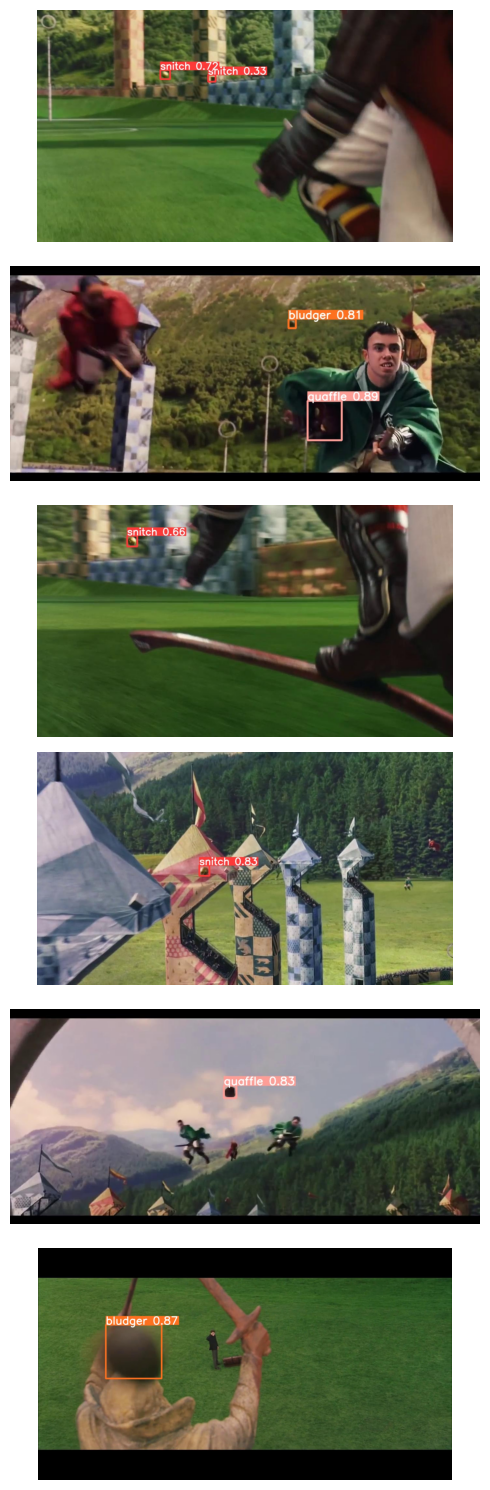

In [41]:
paths2 = ["runs/detect/train22/113.jpg",
          "runs/detect/train23/12.jpg",
          "runs/detect/train24/129.jpg",
          "runs/detect/train211/233.jpg",
          "runs/detect/train26/140.jpg",
          "runs/detect/train27/141.jpg"]

# Создаем одну строку сабплотов
fig, axes = plt.subplots(len(paths2), 1, figsize=(5, 15))  # Увеличиваем ширину фигуры

for ax, path in zip(axes, paths2):
    img = Image.open(path)  # Загружаем изображение
    ax.imshow(img)  # Отображаем изображение
    ax.axis('off')  # Отключаем оси

plt.tight_layout()
plt.show()